In [25]:
from data_reader_writer import *
import itertools as it
import pandas as pd
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV, SGDClassifier, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

%matplotlib inline

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
ephys_data = load_ephys_data()
gamble_choices = load_gamble_choices_data()
behavior_data = load_behavior_data()
regressor_data = load_regressor_data()

In [5]:
gamble_choices.head()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left


In [4]:
sub1_ephys = ephys_data["s1"]
sub1_behavior = behavior_data["s1"]
sub1_behavior.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1


In [5]:
df = pd.concat([sub1_behavior, gamble_choices[["Risky.Bet.Amount", "Risky.bet.shown.number"]]], axis=1)
df.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included,Risky.Bet.Amount,Risky.bet.shown.number
0,1,6.191,6.957,8.003,8.019,8.535,Left,Gamble,Win,1,30,1
1,2,9.550,10.316,11.441,11.457,11.972,Left,Gamble,Win,1,20,4
2,3,12.988,13.753,14.832,14.847,15.363,Left,Safebet,WouldHaveWon,1,25,7
3,4,16.378,17.144,18.144,18.175,18.691,Left,Gamble,Win,1,30,1
4,5,19.707,20.472,21.519,21.550,22.066,Right,Safebet,WouldHaveLost,1,25,6


In [6]:
df['choice.class'].value_counts()

Gamble     124
Safebet     72
Timeout      4
Name: choice.class, dtype: int64

In [7]:
X = df[df['choice.class'] != 'Timeout'][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
X.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [8]:
X.mean()

Risky.Bet.Amount          22.423469
Risky.bet.shown.number     4.831633
dtype: float64

In [9]:
X.max()

Risky.Bet.Amount          30
Risky.bet.shown.number    10
dtype: int64

In [10]:
X.min()

Risky.Bet.Amount          15
Risky.bet.shown.number     0
dtype: int64

In [11]:
(X - X.mean()).head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,7.576531,-3.831633
1,-2.423469,-0.831633
2,2.576531,2.168367
3,7.576531,-3.831633
4,2.576531,1.168367


In [12]:
X.max() - X.min()

Risky.Bet.Amount          15
Risky.bet.shown.number    10
dtype: int64

In [60]:
X_norm = (X - X.mean()) / (X.max() - X.min())
X_norm.head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [61]:
df = X['Risky.Bet.Amount']
df_norm = (df - df.mean()) / (df.max() - df.min())

In [93]:
regressor_data['s8']['rpe'].flatten()[:10]

array([3., 0., 0., 3., 0., 0., 5., 0., 0., 9.])

In [95]:
behavior_data['s8']['outcome'][:10]

0              Win
1     WouldHaveWon
2     WouldHaveWon
3              Win
4    WouldHaveLost
5     WouldHaveWon
6              Win
7    WouldHaveLost
8    WouldHaveLost
9              Win
Name: outcome, dtype: object

In [96]:
gamble_choices.head(10)

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left
5,10,30,1,7,Right
6,10,25,2,5,Right
7,10,20,7,2,Left
8,10,25,9,6,Right
9,10,30,3,8,Left


In [62]:
sub1_behavior[sub1_behavior['choice.class'] == 'Timeout']

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [63]:
idx = sub1_behavior[sub1_behavior['choice.class'] == 'Timeout'].index
idx

Int64Index([11, 15, 110, 156], dtype='int64')

In [64]:
sub1_behavior.iloc[idx]

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.location,choice.class,outcome,trial.included
11,12,44.832,45.597,NaN,47.613,48.128,Timeout,Timeout,Timeout,0
15,16,60.597,61.363,NaN,63.378,63.894,Timeout,Timeout,Timeout,0
110,111,402.800,403.566,NaN,405.582,406.097,Timeout,Timeout,Timeout,0
156,157,562.253,563.019,NaN,565.035,565.550,Timeout,Timeout,Timeout,0


In [6]:
def make_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        data[s] = (X, y)
    return data

In [7]:
def make_normalized_data(subjects=SUBJECTS):
    data = {}
    for s in subjects:
        behav = behavior_data[s]
        non_timeout_idx = behav[behav['choice.class'] != 'Timeout'].index
        X = gamble_choices.iloc[non_timeout_idx][['Risky.Bet.Amount', 'Risky.bet.shown.number']]
        y = behav.iloc[non_timeout_idx]['choice.class'].replace('Gamble', 1).replace('Safebet', 0)
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        X_norm = (X - X.mean()) / (X.max() - X.min()) # normalize data
        data[s] = (X_norm, y)
    return data

In [8]:
def normalize(data):
    return (data - data.mean()) / (data.max() - data.min())

In [9]:
data = make_data()

In [10]:
data_norm = make_normalized_data()

In [70]:
data['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,30,1
1,20,4
2,25,7
3,30,1
4,25,6


In [71]:
type(sub1_ephys['buttonpress_events_hg']) == np.ndarray

True

In [72]:
data_norm['s1'][0].head()

,Risky.Bet.Amount,Risky.bet.shown.number
0,0.505102,-0.383163
1,-0.161565,-0.083163
2,0.171769,0.216837
3,0.505102,-0.383163
4,0.171769,0.116837


In [73]:
type(data_norm['s1'][0]) == pd.core.frame.DataFrame

True

In [102]:
X, y = data['s9']
logr = LogisticRegression()
print("LogisticRegression", cross_val_score(logr, X, y, cv=5)) 
lasso = LassoCV()
print("LassoCV", cross_val_score(lasso, X, y, cv=5)) 
ridge = RidgeCV()
print("RidgeCV", cross_val_score(ridge, X, y, cv=5)) 
linsvc = LinearSVC()
print("LinearSVC", cross_val_score(linsvc, X, y, cv=5))
nusvc = NuSVC()
print("NuSVC", cross_val_score(nusvc, X, y, cv=5))
svc = SVC()
print("SVC", cross_val_score(svc, X, y, cv=5))
dt = DecisionTreeClassifier()
print("DecisionTreeClassifier", cross_val_score(dt, X, y, cv=5))
edt = ExtraTreeClassifier()
print("ExtraTreeClassifier", cross_val_score(edt, X, y, cv=5))
rf = RandomForestClassifier()
print("RandomForestClassifier", cross_val_score(rf, X, y, cv=5))
enet = ElasticNetCV()
print("ElasticNetCV", cross_val_score(enet, X, y, cv=5))
sgd = SGDClassifier()
print("SGDClassifier", cross_val_score(sgd, X, y, cv=5))

LogisticRegression [0.85  0.75  0.7   0.925 0.85 ]
LassoCV [0.58823906 0.48156191 0.27773411 0.63145393 0.59726858]
RidgeCV [0.58790851 0.4817875  0.27912191 0.63098886 0.59660411]


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

LinearSVC [0.775 0.85  0.75  0.975 0.925]
NuSVC [0.9   0.825 0.7   0.975 0.875]
SVC [0.9   0.825 0.7   0.975 0.875]
DecisionTreeClassifier [0.9  0.8  0.7  0.95 0.85]
ExtraTreeClassifier [0.9  0.8  0.7  0.95 0.85]
RandomForestClassifier [0.9   0.825 0.7   0.975 0.875]
ElasticNetCV [0.58823285 0.48156661 0.27784843 0.63144598 0.59718059]
SGDClassifier [0.875 0.65  0.675 0.55  0.8  ]


In [13]:
logr_dict = defaultdict(float)
lsvc_dict = defaultdict(float)
count_dict = defaultdict(int)
for s in SUBJECTS:
    X, y = data_norm[s]
    print(s)
    for C in np.arange(0.1, 1.1, 0.1):
        C = round(C, 1)
        for penalty in ['l1', 'l2']:
            logr = LogisticRegression(penalty=penalty, C=C, fit_intercept=False, dual=False)
            lsvc = LinearSVC(penalty=penalty, C=C, fit_intercept=False, dual=False)
            mean_logr = cross_val_score(logr, X, y, cv=5).mean()
            mean_lsvc = cross_val_score(lsvc, X, y, cv=5).mean()
            logr_dict[(C, penalty)] += mean_logr
            lsvc_dict[(C, penalty)] += mean_lsvc
            count_dict[(C, penalty)] += 1

for key in logr_dict:
    logr_dict[key] /= count_dict[key]
    lsvc_dict[key] /= count_dict[key]

print(logr_dict)
print(lsvc_dict)

s1
s2
s3
s4
s5
s6
s7
s8
s9
s10
defaultdict(<class 'float'>, {(0.1, 'l1'): 0.6547823103669785, (0.1, 'l2'): 0.7055664314011972, (0.2, 'l1'): 0.6857995086158841, (0.2, 'l2'): 0.7063649661997321, (0.3, 'l1'): 0.6929661752825508, (0.3, 'l2'): 0.708104892939659, (0.4, 'l1'): 0.6991241401247261, (0.4, 'l2'): 0.7076048929396588, (0.5, 'l1'): 0.6996241401247262, (0.5, 'l2'): 0.7073906072253731, (0.6, 'l1'): 0.7015398910404771, (0.6, 'l2'): 0.7079034277381936, (0.7, 'l1'): 0.700825438826025, (0.7, 'l2'): 0.7076763215110875, (0.8, 'l1'): 0.705825438826025, (0.8, 'l2'): 0.7076763215110875, (0.9, 'l1'): 0.7060818490824352, (0.9, 'l2'): 0.7095854124201784, (1.0, 'l1'): 0.7061855786861647, (1.0, 'l2'): 0.7100854124201784})
defaultdict(<class 'float'>, {(0.1, 'l1'): 0.6996241401247262, (0.1, 'l2'): 0.705650055094577, (0.2, 'l1'): 0.705825438826025, (0.2, 'l2'): 0.7070719665164885, (0.3, 'l1'): 0.7048479163485024, (0.3, 'l2'): 0.7073576808022028, (0.4, 'l1'): 0.705632955870384, (0.4, 'l2'): 0.70636196

In [133]:
X_norm = normalize(X)
lsvc = LinearSVC(fit_intercept=False).fit(X_norm, y)
print(accuracy_score(lsvc.predict(X_norm), y))
correct = 0
for i in range(len(X_norm)):
    row = X_norm.loc[i]
    a, b = tuple(lsvc.coef_.flatten())
    prod = a * row['Risky.Bet.Amount'] + b * row['Risky.bet.shown.number']
    correct += (y[i] == (prod > 0))

print(correct / len(X_norm))
y.value_counts()

0.845
0.845


0    105
1     95
Name: choice.class, dtype: int64

In [126]:
y[0]

1

In [104]:
svc = SVC(kernel="rbf")
print("SVC", cross_val_score(svc, X, y, cv=5))
svc = SVC(kernel="linear")
print("SVC", cross_val_score(svc, X, y, cv=5))
svc = SVC(kernel="poly")
print("SVC", cross_val_score(svc, X, y, cv=5))
svc = SVC(kernel="sigmoid")
print("SVC", cross_val_score(svc, X, y, cv=5))

SVC [0.9   0.825 0.7   0.975 0.875]
SVC [0.9   0.775 0.7   0.925 0.85 ]
SVC [0.775 0.775 0.7   0.725 0.925]
SVC [0.525 0.525 0.525 0.525 0.525]


In [150]:
LR = "LogisticRegression"
LASSO = "LassoCV"
RIDGE = "RidgeCV"
LSVC = "LinearSVC"
NUSVC = "NuSVC"
SVC_ = "SVC"
ELNET = "ElasticNetCV"
SGD = "SGDClassifier"
DTREE = "DecisionTreeClassifier"
RF = "RandomForestClassifier"
MODELS = [LR, LASSO, RIDGE, LSVC, NUSVC, SVC_, ELNET, SGD, DTREE, RF]

In [22]:
np.array([[1,2], [3,4]]).mean(axis=0)

A = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
b = np.array([1, 2, 3, 4])
kf = KFold(n_splits=4)
for i1, i2 in kf.split(A):
    print(i1, i2)

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [31]:
sgd = SGDClassifier()
sgd.fit(X, y)
y_pred = sgd.predict(X)
precision_recall_fscore_support(y, y_pred, average='weighted')

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(0.8083623693379792, 0.8, 0.7974296205630356, None)

In [67]:
np.random.shuffle(np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]]))

In [165]:
def cross_validation(X, y, model, k=5, C=1.0, fit_intercept=True, kernel="rbf", gamma="auto", shuffle=False):
    test_accuracies = []
    train_accuracies = []
    test_metrics = []
    train_metrics = []
    X_weights = []
    kf = KFold(n_splits=k)
    split = round(len(X) * 0.8)
    indices = list(range(len(X)))
#     print(model)
    
    for idx_tr, idx_te in kf.split(X):
        if shuffle:
            np.random.shuffle(indices)
            idx_tr = indices[:split]
            idx_te = indices[split:]
            
        if type(X) == pd.core.frame.DataFrame:
            X_train = X.iloc[idx_tr]
            y_train = y.iloc[idx_tr]

            X_test = X.iloc[idx_te]
            y_test = y.iloc[idx_te]
        elif type(X) == np.ndarray:
            X_train = X[idx_tr]
            y_train = y[idx_tr]

            X_test = X[idx_te]
            y_test = y[idx_te]

        
        if model == LR:
            logr = LogisticRegression(C=C, fit_intercept=fit_intercept, dual=False)
            logr.fit(X_train, y_train)
            y_test_pred = logr.predict(X_test)
            y_train_pred = logr.predict(X_train)
            X_weights.append(logr.coef_)
        
        elif model == LSVC:
            lsvc = LinearSVC(C=C, fit_intercept=fit_intercept, dual=False)
            lsvc.fit(X_train, y_train)
            y_test_pred = lsvc.predict(X_test)
            y_train_pred = lsvc.predict(X_train)
            X_weights.append(lsvc.coef_)
            
        elif model == SVC_:
            svc = SVC(C=C, kernel=kernel, gamma=gamma)
            svc.fit(X_train, y_train)
            y_test_pred = svc.predict(X_test)
            y_train_pred = svc.predict(X_train)
            if kernel == "linear":
                X_weights.append(svc.coef_)
        
        elif model == NUSVC:
            nusvc = NuSVC()
            nusvc.fit(X_train, y_train)
            y_test_pred = nusvc.predict(X_test)
            y_train_pred = nusvc.predict(X_train)

        elif model == LASSO:
            lasso = LassoCV()
            lasso.fit(X_train, y_train)
            y_test_pred = lasso.predict(X_test)
            y_train_pred = lasso.predict(X_train)
  
        elif model == RIDGE:
            ridge = RidgeCV()
            ridge.fit(X_train, y_train)
            y_test_pred = ridge.predict(X_test)
            y_train_pred = ridge.predict(X_train)
        
        elif model == DTREE:
            dt = DecisionTreeClassifier()
            dt.fit(X_train, y_train)
            y_test_pred = dt.predict(X_test)
            y_train_pred = dt.predict(X_train)
            
        elif model == RF:
            rf = RandomForestClassifier()
            rf.fit(X_train, y_train)
            y_test_pred = rf.predict(X_test)
            y_train_pred = rf.predict(X_train)
            
        elif model == ELNET:
            elnet = ElasticNetCV()
            elnet.fit(X_train, y_train)
            y_test_pred = elnet.predict(X_test)
            y_train_pred = elnet.predict(X_train)
            
        elif model == SGD:
            sgd = SGDClassifier()
            sgd.fit(X_train, y_train)
            y_test_pred = sgd.predict(X_test)
            y_train_pred = sgd.predict(X_train)
        
        test_accuracies.append(accuracy_score(y_test, y_test_pred))
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        test_metrics.append(precision_recall_fscore_support(y_test, y_test_pred, average='weighted')[:3]) # exclude support
        train_metrics.append(precision_recall_fscore_support(y_train, y_train_pred, average='weighted')[:3])
        

    
    mean_test = round(np.array(test_accuracies).mean(), 3)
    mean_train = round(np.array(train_accuracies).mean(), 3)
    # metrics -- 3 floats: precision, recall, f-score
    mean_test_metrics = np.array(test_metrics).mean(axis=0)
    mean_train_metrics = np.array(train_metrics).mean(axis=0)
    
    mean_weights = None if X_weights == [] else np.array(X_weights).mean(axis=0)[0]
    
    return mean_weights, mean_test, mean_train, mean_test_metrics, mean_train_metrics

In [159]:
np.array([1.2, 1.5, 1.6, 0]).round()

array([1., 2., 2., 0.])

In [69]:
def test_models(data, models, C=1.0, fit_intercept=True, shuffle=False):
    results = defaultdict(dict)
    for m in models:
        mean_coefs = []
        test_accs = []
        train_accs = []
        test_fscores = []
        train_fscores = []
        test_precisions = []
        train_precisions = []
        test_recalls = []
        train_recalls = []
        for s in SUBJECTS:
            X, y = data[s]
            print("Subject", s)
            coefs, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, m, C=C, 
                                                                                                   fit_intercept=fit_intercept,
                                                                                                   shuffle=shuffle)
            mean_coefs.append(coefs)
            test_accs.append(mean_test)
            train_accs.append(mean_train)
            test_precisions.append(mean_test_metrics[0])
            train_precisions.append(mean_train_metrics[0])
            test_recalls.append(mean_test_metrics[1])
            train_recalls.append(mean_train_metrics[1])
            test_fscores.append(mean_test_metrics[2])
            train_fscores.append(mean_train_metrics[2])
            
            print("Model %s, mean test acc %f, train acc %f, mean test f-score %f, train f-score %f" % 
                  (m, mean_test, mean_train, mean_test_metrics[2], mean_train_metrics[2]))
            
        results[m]["mean_coefs"] = mean_coefs
        results[m]["test_accs"] = test_accs
        results[m]["train_accs"] = train_accs
        results[m]["test_f-scores"] = test_fscores
        results[m]["train_f-scores"] = train_fscores
        results[m]["test_precisions"] = test_precisions
        results[m]["train_precisions"] = train_precisions
        results[m]["test_recalls"] = test_recalls
        results[m]["train_recalls"] = train_recalls

    return results

In [230]:
results = test_models(data, [LR, LSVC], C=0.5, fit_intercept=False)

Subject s1
Model LogisticRegression, mean test acc 0.751000, train acc 0.767000, mean test f-score 0.747722, train f-score 0.765737
Subject s2
Model LogisticRegression, mean test acc 0.818000, train acc 0.833000, mean test f-score 0.817414, train f-score 0.833882
Subject s3
Model LogisticRegression, mean test acc 0.660000, train acc 0.650000, mean test f-score 0.656287, train f-score 0.646215
Subject s4


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Model LogisticRegression, mean test acc 0.353000, train acc 0.547000, mean test f-score 0.296195, train f-score 0.480091
Subject s5
Model LogisticRegression, mean test acc 0.679000, train acc 0.740000, mean test f-score 0.597234, train f-score 0.658779
Subject s6
Model LogisticRegression, mean test acc 0.765000, train acc 0.771000, mean test f-score 0.764054, train f-score 0.772336
Subject s7
Model LogisticRegression, mean test acc 0.850000, train acc 0.849000, mean test f-score 0.847159, train f-score 0.847896
Subject s8
Model LogisticRegression, mean test acc 0.670000, train acc 0.680000, mean test f-score 0.672258, train f-score 0.676679
Subject s9
Model LogisticRegression, mean test acc 0.800000, train acc 0.813000, mean test f-score 0.794853, train f-score 0.811183
Subject s10


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Model LogisticRegression, mean test acc 0.515000, train acc 0.571000, mean test f-score 0.403112, train f-score 0.469178
Subject s1


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model LinearSVC, mean test acc 0.760000, train acc 0.756000, mean test f-score 0.757288, train f-score 0.753751
Subject s2
Model LinearSVC, mean test acc 0.808000, train acc 0.849000, mean test f-score 0.807312, train f-score 0.848061
Subject s3


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.685000, train acc 0.639000, mean test f-score 0.679246, train f-score 0.631214
Subject s4


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: Convergen

Model LinearSVC, mean test acc 0.517000, train acc 0.541000, mean test f-score 0.403475, train f-score 0.423967
Subject s5


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\si

Model LinearSVC, mean test acc 0.724000, train acc 0.730000, mean test f-score 0.636486, train f-score 0.636270
Subject s6


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.790000, train acc 0.790000, mean test f-score 0.787605, train f-score 0.788854
Subject s7


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model LinearSVC, mean test acc 0.855000, train acc 0.851000, mean test f-score 0.852452, train f-score 0.850841
Subject s8


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

Model LinearSVC, mean test acc 0.575000, train acc 0.656000, mean test f-score 0.559272, train f-score 0.630726
Subject s9


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model LinearSVC, mean test acc 0.820000, train acc 0.809000, mean test f-score 0.815817, train f-score 0.806790
Subject s10
Model LinearSVC, mean test acc 0.537000, train acc 0.549000, mean test f-score 0.413503, train f-score 0.429931


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:

In [40]:
results_norm = test_models(data_norm, [LR, LSVC], C=0.5, fit_intercept=False)

Subject s1
Model LogisticRegression, mean test acc 0.709000, train acc 0.731000, mean test f-score 0.712878, train f-score 0.735406
Subject s2
Model LogisticRegression, mean test acc 0.889000, train acc 0.888000, mean test f-score 0.889449, train f-score 0.887931
Subject s3
Model LogisticRegression, mean test acc 0.720000, train acc 0.718000, mean test f-score 0.720356, train f-score 0.717371
Subject s4
Model LogisticRegression, mean test acc 0.485000, train acc 0.513000, mean test f-score 0.496644, train f-score 0.514283
Subject s5
Model LogisticRegression, mean test acc 0.588000, train acc 0.577000, mean test f-score 0.617488, train f-score 0.601277
Subject s6
Model LogisticRegression, mean test acc 0.865000, train acc 0.865000, mean test f-score 0.866559, train f-score 0.865860
Subject s7
Model LogisticRegression, mean test acc 0.895000, train acc 0.895000, mean test f-score 0.894536, train f-score 0.894895
Subject s8
Model LogisticRegression, mean test acc 0.700000, train acc 0.709

In [23]:
results_norm_2 = test_models(data_norm, [LR, LSVC], C=1, fit_intercept=False) # with dual = False

Subject s1
Model LogisticRegression, mean test acc 0.709000, train acc 0.731000, mean test f-score 0.712878, train f-score 0.735406
Subject s2
Model LogisticRegression, mean test acc 0.889000, train acc 0.888000, mean test f-score 0.889449, train f-score 0.887931
Subject s3
Model LogisticRegression, mean test acc 0.720000, train acc 0.718000, mean test f-score 0.720356, train f-score 0.717371
Subject s4
Model LogisticRegression, mean test acc 0.494000, train acc 0.518000, mean test f-score 0.507164, train f-score 0.518962
Subject s5
Model LogisticRegression, mean test acc 0.588000, train acc 0.577000, mean test f-score 0.617488, train f-score 0.601277
Subject s6
Model LogisticRegression, mean test acc 0.880000, train acc 0.879000, mean test f-score 0.881076, train f-score 0.879607
Subject s7
Model LogisticRegression, mean test acc 0.895000, train acc 0.895000, mean test f-score 0.894536, train f-score 0.894895
Subject s8
Model LogisticRegression, mean test acc 0.700000, train acc 0.709

In [171]:
results_norm_3 = test_models(data_norm, [DTREE, RF], C=1, fit_intercept=False) # with dual = False

Subject s1
Model DecisionTreeClassifier, mean test acc 0.735000, train acc 0.829000, mean test f-score 0.730932, train f-score 0.829364
Subject s2
Model DecisionTreeClassifier, mean test acc 0.909000, train acc 0.931000, mean test f-score 0.909082, train f-score 0.930731
Subject s3
Model DecisionTreeClassifier, mean test acc 0.735000, train acc 0.805000, mean test f-score 0.734033, train f-score 0.803968
Subject s4
Model DecisionTreeClassifier, mean test acc 0.523000, train acc 0.757000, mean test f-score 0.535884, train f-score 0.751817
Subject s5
Model DecisionTreeClassifier, mean test acc 0.648000, train acc 0.790000, mean test f-score 0.640550, train f-score 0.784282
Subject s6
Model DecisionTreeClassifier, mean test acc 0.930000, train acc 0.935000, mean test f-score 0.929752, train f-score 0.935075
Subject s7
Model DecisionTreeClassifier, mean test acc 0.865000, train acc 0.914000, mean test f-score 0.864469, train f-score 0.913661
Subject s8
Model DecisionTreeClassifier, mean te

In [173]:
results_norm_4 = test_models(data_norm, [ELNET, NUSVC], C=1, fit_intercept=False) # with dual = False

Subject s1


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [20]:
# metric -- 'accs', 'precisions', 'recalls', 'f-scores'
def plot_model_metrics(results, metric="accs", plot_title=None):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    test_key = "test_" + metric
    train_key = "train_" + metric
    ylabel = metric[:-1] if metric != "accs" else "accuracy"
    title = metric if metric != "accs" else "accuracies"
    for i in range(len(results)):
        m = models[i] # model name
        data = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "metric": results[m][test_key] + results[m][train_key], 
                                 "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
        sns.pointplot(x="subject", y="metric", hue="type", data=data, dodge=True, ax=axes[i]).set(
            title=m + " " + title, ylabel=ylabel)
    
    if plot_title != None:
        save_fig(fig, plot_title)

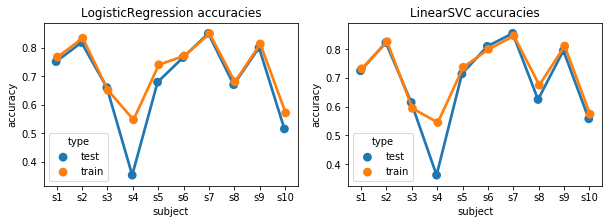

In [211]:
plot_model_metrics(results, plot_title="LR_LSVC_accs_2")

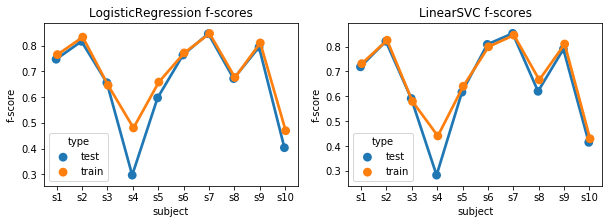

In [212]:
plot_model_metrics(results, metric="f-scores", plot_title="LR_LSVC_fscores_2")

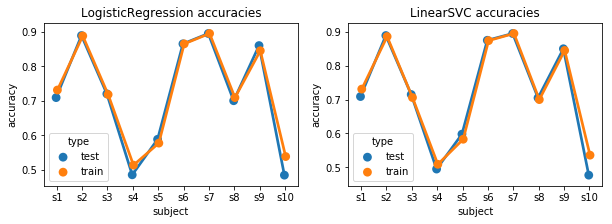

In [213]:
plot_model_metrics(results_norm, plot_title="LR_LSVC_accs_norm_2")

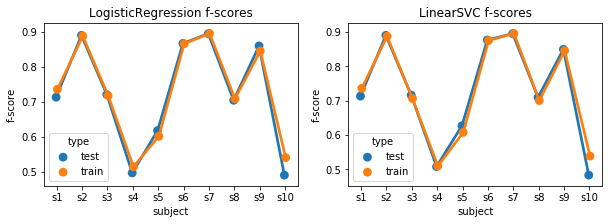

In [214]:
plot_model_metrics(results_norm, metric="f-scores", plot_title="LR_LSVC_fscores_norm_2")

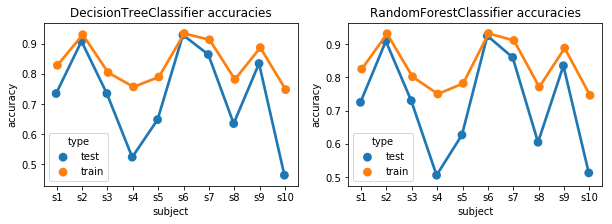

In [172]:
plot_model_metrics(results_norm_3)

In [36]:
for s in SUBJECTS:
    unique, counts = np.unique(regressor_data[s]['gamble_ind'], return_counts=True)
    d = dict(zip(unique, counts))
    print("0: %s, 1: %s" % (str(round(d[0] / N_TRIALS[s], 2)), str(round(d[1] / N_TRIALS[s], 2))))

0: 0.36, 1: 0.64
0: 0.46, 1: 0.54
0: 0.53, 1: 0.47
0: 0.55, 1: 0.45
0: 0.27, 1: 0.73
0: 0.42, 1: 0.58
0: 0.51, 1: 0.49
0: 0.5, 1: 0.5
0: 0.52, 1: 0.48
0: 0.42, 1: 0.58


In [37]:
np.abs([-1, 1])

array([1, 1])

In [38]:
def plot_model_coefs(results, plot_title=None, use_absolute_values=False):
    rows = round(len(results) / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows))
    axes = axes.flatten()
    
    models = list(results.keys())
    for i in range(len(results)):
        m = models[i] # model name

        if use_absolute_values:
            data = pd.DataFrame({"prize_coef": np.abs(np.array(results[m]["mean_coefs"])[:, 0]),
                                    "rnd_nr_coef": np.abs(np.array(results[m]["mean_coefs"])[:, 1]), 
                                    "subject": SUBJECTS}) 
        else:    
            data = pd.DataFrame({"prize_coef": np.array(results[m]["mean_coefs"])[:, 0],
                                    "rnd_nr_coef": np.array(results[m]["mean_coefs"])[:, 1], 
                                    "subject": SUBJECTS}) 
        sns.scatterplot(x="prize_coef", y="rnd_nr_coef", hue="subject", data=data, ax=axes[i]).set(
            title="%s coefs" % m)

        # Show only one legend 
        if i < len(results) - 1:
            axes[i].legend().remove()
        else:
            axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if plot_title != None:
        save_fig(fig, plot_title)

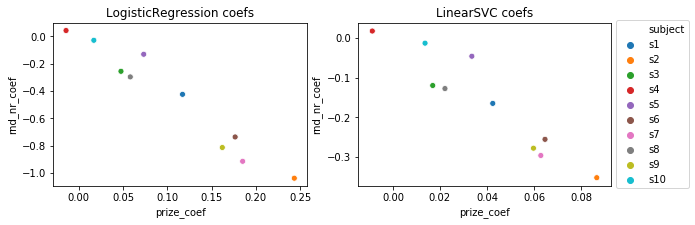

In [216]:
plot_model_coefs(results, "LR_LSVC_coefs_2")

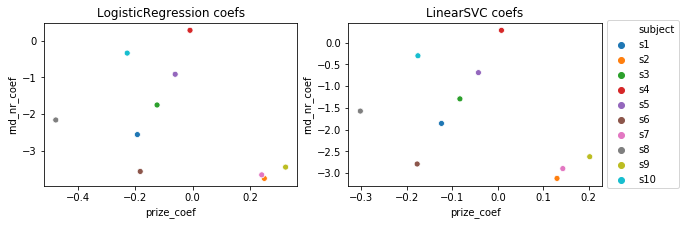

In [217]:
plot_model_coefs(results_norm, "LR_LSVC_coefs_norm_2")

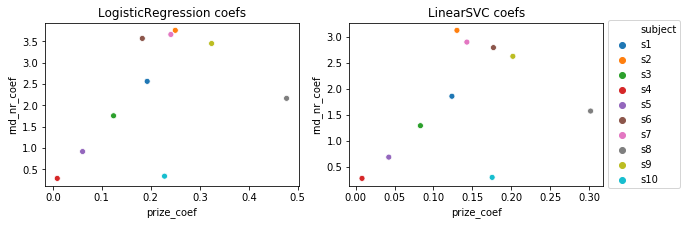

In [41]:
plot_model_coefs(results_norm, use_absolute_values=True)

In [27]:
def calculate_winnings():
    winnings = defaultdict(int) # keys: s1, ..., s10, perfect (picked the best option all the time), expected (picked so that
    # expected value = prize * win probability > 0.5 * 18 = 9)
    avg_per_trial = defaultdict(float) # same keys
    
    for i in range(200):
        prize = gamble_choices.iloc[i]['Risky.Bet.Amount']
            
        for s in SUBJECTS:
            if i < len(behavior_data[s]) and behavior_data[s].iloc[i]['trial.included'] == 1:
                outcome = behavior_data[s].iloc[i]['outcome']
                if outcome == 'Win':
                    winnings[s] += prize
                elif outcome == 'WouldHaveWon' or outcome == 'WouldHaveLost':
                    winnings[s] += 10
                
                # First, let's store counts in there
                avg_per_trial[s] += 1
        
        winnings['perfect'] += prize
    
    for s in SUBJECTS:
        avg_per_trial[s] = round(winnings[s] / avg_per_trial[s], 2)
    
    avg_per_trial['perfect'] = round(winnings['perfect'] / 200, 2)
    return winnings, avg_per_trial

calculate_winnings()

(defaultdict(int,
             {'s1': 2400,
              's3': 2405,
              's6': 2600,
              's7': 2485,
              's8': 2475,
              's9': 2760,
              's10': 1475,
              'perfect': 4465,
              's2': 2625,
              's5': 2230,
              's4': 1090}),
 defaultdict(float,
             {'s1': 13.33,
              's3': 12.4,
              's6': 13.9,
              's7': 13.73,
              's8': 12.38,
              's9': 13.8,
              's10': 10.85,
              's2': 13.96,
              's5': 12.46,
              's4': 10.09,
              'perfect': 22.32}))

In [59]:
regressor_data['s8']['risk'].flatten()[:10]

array([0.09, 0.24, 0.21, 0.09, 0.24, 0.09, 0.16, 0.21, 0.09, 0.21])

In [58]:
gamble_choices.head(10)#['Risky.bet.hidden.number'].var()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left
5,10,30,1,7,Right
6,10,25,2,5,Right
7,10,20,7,2,Left
8,10,25,9,6,Right
9,10,30,3,8,Left


In [ ]:
def calculate_expected_winnings():
    winnings = defaultdict(int) 
    
    exp_vals = []
    avg_per_trial = defaultdict(float) # same keys
    exp_val_limit = 0.5 * 18
    unexpected = 0
    unexpected_loss = 0
    
    for i in range(200):
        prize = gamble_choices.iloc[i]['Risky.Bet.Amount']
        risky_nr_1 = gamble_choices.iloc[i]['Risky.bet.shown.number']
        risky_nr_2 = gamble_choices.iloc[i]['Risky.bet.hidden.number']
        win_prob = (10 - risky_nr_1) / 10
        exp_val = prize * win_prob
        will_gamble = exp_val > exp_val_limit
        expected_result = None
        if risky_nr_2 > risky_nr_1 and will_gamble:
            winnings['expected'] += prize
        elif not will_gamble:
            winnings['expected'] += 10
        
        if risky_nr_2 < risky_nr_1 and will_gamble or risky_nr_2 > risky_nr_1 and not will_gamble:
            unexpected += 1
            unexpected_loss += prize if risky_nr_2 > risky_nr_1 else 10

    avg_per_trial['expected'] = round(winnings['expected'] / 200, 2)
    print("Unexpected: %d, loss: %d" % (unexpected, unexpected_loss))
    
    return winnings, avg_per_trial
    

In [21]:
gamble_choices.min()

Safe.Bet.Amount              10
Risky.Bet.Amount             15
Risky.bet.shown.number        0
Risky.bet.hidden.number       0
Risky.Side                 Left
dtype: object

In [44]:
all_datasets = load_var("all_datasets_2")

In [151]:
regressor_data['s9']['gamble_ind'].flatten()#[[1, 3, 5]]

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0], dtype=uint8)

In [152]:
dataset_1 = all_datasets[('s9', GAMEPRES_BUTTONPRESS, ALL, 2, True)]
y1 = regressor_data['s9']['gamble_ind'].flatten()

In [153]:
logr = LogisticRegression(solver="liblinear")
print("LogisticRegression", np.array(cross_val_score(logr, normalize(dataset_1), y1, cv=5)).mean()) 

LogisticRegression 0.5199999999999999


In [154]:
y2 = regressor_data['s9']['winprob'].flatten()

In [155]:
# linreg = LinearRegression()
svr = LinearSVR()
print(np.array(cross_val_score(svr, normalize(dataset_1), y2, cv=5)).mean())

-0.1355661391783453


In [167]:
regression_results = defaultdict(lambda: defaultdict(dict))
MODELS = [LR, LSVC, SVC_, SGD, DTREE, RF]

for key in all_datasets:
    s, tw_type, trial_type, tw_per_el, use_all_els = key
    if not use_all_els:
        continue
    
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    s_behav = s_behav.reset_index(drop=True)
    
    indices = None
    if trial_type == ALL:
        indices = s_behav.index
    else:
        continue
        
    assert len(indices) == len(all_datasets[key]), "Lengths do not correspond!"
    
    X = normalize(all_datasets[key])
    if tw_type == GAMEPRES_BUTTONPRESS:
        y = regressor_data[s]["gamble_ind"].flatten()[indices]
        
        for model in MODELS:
            _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, model, shuffle=False)
            regression_results[key]["gamble_ind"][model] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)

#         _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LR, shuffle=False)
#         regression_results[key]["gamble_ind"][LR] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
#         _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LSVC, shuffle=False)
#         regression_results[key]["gamble_ind"][LSVC] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
#         _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, SVC_, shuffle=False)
#         regression_results[key]["gamble_ind"][SVC_] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
    else:
        for regr in ["loss_ind", "win_ind"]:
            y = regressor_data[s][regr].flatten()[indices]
            
            for model in MODELS:
                print(model)
                _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, model, shuffle=False)
                regression_results[key][regr][model] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)

#             _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LR, shuffle=False)
#             regression_results[key][regr][LR] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
#             _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, LSVC, shuffle=False)
#             regression_results[key][regr][LSVC] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)
#             _, mean_test, mean_train, mean_test_metrics, mean_train_metrics = cross_validation(X, y, SVC_, shuffle=False)
#             regression_results[key][regr][SVC_] = (mean_test, mean_train, mean_test_metrics, mean_train_metrics)

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\U

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\U

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier
LogisticRegression


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier
LogisticRegression


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
LinearSVC
SVC


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression
LinearSVC
SVC


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\U

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier
LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\U

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

RandomForestClassifier
LogisticRegression
LinearSVC


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\U

SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

LogisticRegression
LinearSVC
SVC
SGDClassifier
DecisionTreeClassifier
RandomForestClassifier


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

In [168]:
regression_results[('s1', '1.5s after outcome reveal', 'all', 1, True)].keys()

dict_keys(['loss_ind', 'win_ind'])

In [169]:
regression_results[list(regression_results.keys())[0]]['loss_ind']

{'LogisticRegression': (0.794,
  0.794,
  array([0.63410494, 0.79444444, 0.70449992]),
  array([0.63132716, 0.79444444, 0.70350358])),
 'LinearSVC': (0.8,
  0.8,
  array([0.67140653, 0.8       , 0.71635473]),
  array([0.79738079, 0.8       , 0.71643921])),
 'SVC': (0.794,
  0.794,
  array([0.63410494, 0.79444444, 0.70449992]),
  array([0.63132716, 0.79444444, 0.70350358])),
 'SGDClassifier': (0.789,
  0.796,
  array([0.63331129, 0.78888889, 0.70170271]),
  array([0.75114066, 0.79583333, 0.71409882])),
 'DecisionTreeClassifier': (0.656,
  1.0,
  array([0.67664295, 0.65555556, 0.66340386]),
  array([1., 1., 1.])),
 'RandomForestClassifier': (0.794,
  0.961,
  array([0.74792208, 0.79444444, 0.72969993]),
  array([0.96293828, 0.96111111, 0.95951048]))}

In [117]:
result_statistics_LR = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0]))) 
counts = defaultdict(lambda: defaultdict(int))
result_statistics_LSVC = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0])))
result_statistics_DT = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0])))
result_statistics_RF = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0])))

# keys for result statistics: 'regressor', 'subject', 'tw_type', 'trial_type', 'use_all_els'
# 2nd layer keys: different param values
# results_statistics[param][param_value] = [mean test acc, mean test precision, mean test recall, mean test f-score]


for key1 in regression_results:
    s, tw_type, trial_type, tw_per_el, use_all_els = key1
    
    for key2 in regression_results[key1]:
        test_acc_LR = regression_results[key1][key2][LR][0]
        test_acc_LSVC = regression_results[key1][key2][LSVC][0]
        test_metrics_LR = regression_results[key1][key2][LR][2]
        test_metrics_LSVC = regression_results[key1][key2][LSVC][2]
        
        counts['combo'][key1] += 1
        result_statistics_LR['combo'][key1][0] += test_acc_LR
        result_statistics_LSVC['combo'][key1][0] += test_acc_LSVC
        result_statistics_LR['combo'][key1][1] += test_metrics_LR[0]
        result_statistics_LSVC['combo'][key1][1] += test_metrics_LSVC[0]
        result_statistics_LR['combo'][key1][2] += test_metrics_LR[1]
        result_statistics_LSVC['combo'][key1][2] += test_metrics_LSVC[1]
        result_statistics_LR['combo'][key1][3] += test_metrics_LR[2]
        result_statistics_LSVC['combo'][key1][3] += test_metrics_LSVC[2]
        
        counts['regressor'][key2] += 1
        result_statistics_LR['regressor'][key2][0] += test_acc_LR
        result_statistics_LSVC['regressor'][key2][0] += test_acc_LSVC
        result_statistics_LR['regressor'][key2][1] += test_metrics_LR[0]
        result_statistics_LSVC['regressor'][key2][1] += test_metrics_LSVC[0]
        result_statistics_LR['regressor'][key2][2] += test_metrics_LR[1]
        result_statistics_LSVC['regressor'][key2][2] += test_metrics_LSVC[1]
        result_statistics_LR['regressor'][key2][3] += test_metrics_LR[2]
        result_statistics_LSVC['regressor'][key2][3] += test_metrics_LSVC[2]
        
        counts['subject'][s] += 1
        result_statistics_LR['subject'][s][0] += test_acc_LR
        result_statistics_LSVC['subject'][s][0] += test_acc_LSVC
        result_statistics_LR['subject'][s][1] += test_metrics_LR[0]
        result_statistics_LSVC['subject'][s][1] += test_metrics_LSVC[0]
        result_statistics_LR['subject'][s][2] += test_metrics_LR[1]
        result_statistics_LSVC['subject'][s][2] += test_metrics_LSVC[1]
        result_statistics_LR['subject'][s][3] += test_metrics_LR[2]
        result_statistics_LSVC['subject'][s][3] += test_metrics_LSVC[2]
        
        counts['tw_type'][tw_type] += 1
        result_statistics_LR['tw_type'][tw_type][0] += test_acc_LR
        result_statistics_LSVC['tw_type'][tw_type][0] += test_acc_LSVC
        result_statistics_LR['tw_type'][tw_type][1] += test_metrics_LR[0]
        result_statistics_LSVC['tw_type'][tw_type][1] += test_metrics_LSVC[0]
        result_statistics_LR['tw_type'][tw_type][2] += test_metrics_LR[1]
        result_statistics_LSVC['tw_type'][tw_type][2] += test_metrics_LSVC[1]
        result_statistics_LR['tw_type'][tw_type][3] += test_metrics_LR[2]
        result_statistics_LSVC['tw_type'][tw_type][3] += test_metrics_LSVC[2]
        
        counts['trial_type'][trial_type] += 1
        result_statistics_LR['trial_type'][trial_type][0] += test_acc_LR
        result_statistics_LSVC['trial_type'][trial_type][0] += test_acc_LSVC
        result_statistics_LR['trial_type'][trial_type][1] += test_metrics_LR[0]
        result_statistics_LSVC['trial_type'][trial_type][1] += test_metrics_LSVC[0]
        result_statistics_LR['trial_type'][trial_type][2] += test_metrics_LR[1]
        result_statistics_LSVC['trial_type'][trial_type][2] += test_metrics_LSVC[1]
        result_statistics_LR['trial_type'][trial_type][3] += test_metrics_LR[2]
        result_statistics_LSVC['trial_type'][trial_type][3] += test_metrics_LSVC[2]
        
        counts['tw_per_el'][tw_per_el] += 1
        result_statistics_LR['tw_per_el'][tw_per_el][0] += test_acc_LR
        result_statistics_LSVC['tw_per_el'][tw_per_el][0] += test_acc_LSVC
        result_statistics_LR['tw_per_el'][tw_per_el][1] += test_metrics_LR[0]
        result_statistics_LSVC['tw_per_el'][tw_per_el][1] += test_metrics_LSVC[0]
        result_statistics_LR['tw_per_el'][tw_per_el][2] += test_metrics_LR[1]
        result_statistics_LSVC['tw_per_el'][tw_per_el][2] += test_metrics_LSVC[1]
        result_statistics_LR['tw_per_el'][tw_per_el][3] += test_metrics_LR[2]
        result_statistics_LSVC['tw_per_el'][tw_per_el][3] += test_metrics_LSVC[2]
        
        counts['use_all_els'][use_all_els] += 1
        result_statistics_LR['use_all_els'][use_all_els][0] += test_acc_LR
        result_statistics_LSVC['use_all_els'][use_all_els][0] += test_acc_LSVC
        result_statistics_LR['use_all_els'][use_all_els][1] += test_metrics_LR[0]
        result_statistics_LSVC['use_all_els'][use_all_els][1] += test_metrics_LSVC[0]
        result_statistics_LR['use_all_els'][use_all_els][2] += test_metrics_LR[1]
        result_statistics_LSVC['use_all_els'][use_all_els][2] += test_metrics_LSVC[1]
        result_statistics_LR['use_all_els'][use_all_els][3] += test_metrics_LR[2]
        result_statistics_LSVC['use_all_els'][use_all_els][3] += test_metrics_LSVC[2]
        
for key1 in result_statistics_LR:
    for key2 in result_statistics_LR[key1]:
        result_statistics_LR[key1][key2] /= counts[key1][key2]
        result_statistics_LR[key1][key2] = np.round(result_statistics_LR[key1][key2], 3)
        result_statistics_LSVC[key1][key2] /= counts[key1][key2]
        result_statistics_LSVC[key1][key2] = np.round(result_statistics_LSVC[key1][key2], 3)

In [118]:
sorted(result_statistics_LR['regressor'].items(), key=lambda x: x[1][3], reverse=True)

[('loss_ind', array([0.816, 0.678, 0.816, 0.738])),
 ('win_ind', array([0.637, 0.472, 0.637, 0.517])),
 ('gamble_ind', array([0.556, 0.491, 0.556, 0.484]))]

In [119]:
sorted(result_statistics_LSVC['regressor'].items(), key=lambda x: x[1][3], reverse=True)

[('loss_ind', array([0.813, 0.698, 0.813, 0.741])),
 ('win_ind', array([0.63 , 0.579, 0.63 , 0.562])),
 ('gamble_ind', array([0.565, 0.539, 0.565, 0.519]))]

In [120]:
sorted(result_statistics_LR['subject'].items(), key=lambda x: x[1][3], reverse=True)

[('s9', array([0.689, 0.663, 0.689, 0.64 ])),
 ('s3', array([0.685, 0.6  , 0.685, 0.621])),
 ('s8', array([0.663, 0.637, 0.663, 0.605])),
 ('s7', array([0.67 , 0.575, 0.67 , 0.596])),
 ('s4', array([0.669, 0.544, 0.668, 0.588])),
 ('s2', array([0.656, 0.555, 0.656, 0.572])),
 ('s6', array([0.668, 0.487, 0.668, 0.55 ])),
 ('s5', array([0.665, 0.484, 0.665, 0.547])),
 ('s1', array([0.667, 0.457, 0.667, 0.539])),
 ('s10', array([0.664, 0.468, 0.664, 0.539]))]

In [121]:
sorted(result_statistics_LSVC['subject'].items(), key=lambda x: x[1][3], reverse=True)

[('s9', array([0.701, 0.685, 0.701, 0.673])),
 ('s8', array([0.678, 0.652, 0.678, 0.64 ])),
 ('s3', array([0.665, 0.625, 0.665, 0.637])),
 ('s2', array([0.668, 0.625, 0.668, 0.625])),
 ('s7', array([0.663, 0.623, 0.663, 0.619])),
 ('s4', array([0.675, 0.623, 0.675, 0.61 ])),
 ('s5', array([0.661, 0.59 , 0.661, 0.592])),
 ('s10', array([0.657, 0.574, 0.657, 0.578])),
 ('s6', array([0.664, 0.566, 0.664, 0.559])),
 ('s1', array([0.659, 0.492, 0.659, 0.541]))]

In [122]:
sorted(result_statistics_LR['trial_type'].items(), key=lambda x: x[1][3], reverse=True)

[('all', array([0.67 , 0.547, 0.67 , 0.58 ]))]

In [123]:
sorted(result_statistics_LSVC['trial_type'].items(), key=lambda x: x[1][3], reverse=True)

[('all', array([0.669, 0.606, 0.669, 0.607]))]

In [124]:
sorted(result_statistics_LR['tw_type'].items(), key=lambda x: x[1][3], reverse=True)

[('1.5s after outcome reveal', array([0.726, 0.575, 0.726, 0.627])),
 ('between game presentation and buttonpress',
  array([0.556, 0.491, 0.556, 0.484]))]

In [125]:
sorted(result_statistics_LSVC['tw_type'].items(), key=lambda x: x[1][3], reverse=True)

[('1.5s after outcome reveal', array([0.721, 0.639, 0.721, 0.651])),
 ('between game presentation and buttonpress',
  array([0.565, 0.539, 0.565, 0.519]))]

In [126]:
sorted(result_statistics_LR['use_all_els'].items(), key=lambda x: x[1][3], reverse=True)

[(True, array([0.67 , 0.547, 0.67 , 0.58 ]))]

In [127]:
sorted(result_statistics_LSVC['use_all_els'].items(), key=lambda x: x[1][3], reverse=True)

[(True, array([0.669, 0.606, 0.669, 0.607]))]

In [128]:
sorted(result_statistics_LR['tw_per_el'].items(), key=lambda x: x[1][3], reverse=True)

[(3, array([0.671, 0.55 , 0.671, 0.583])),
 (2, array([0.669, 0.55 , 0.669, 0.58 ])),
 (1, array([0.669, 0.541, 0.669, 0.576]))]

In [129]:
sorted(result_statistics_LSVC['tw_per_el'].items(), key=lambda x: x[1][3], reverse=True)

[(3, array([0.673, 0.612, 0.673, 0.615])),
 (2, array([0.668, 0.607, 0.668, 0.607])),
 (1, array([0.667, 0.597, 0.667, 0.6  ]))]

In [130]:
sorted(result_statistics_LR['combo'].items(), key=lambda x: x[1][3], reverse=True)[:5]

[(('s9', '1.5s after outcome reveal', 'all', 3, True),
  array([0.778, 0.71 , 0.778, 0.72 ])),
 (('s9', '1.5s after outcome reveal', 'all', 2, True),
  array([0.775, 0.712, 0.775, 0.713])),
 (('s9', '1.5s after outcome reveal', 'all', 1, True),
  array([0.775, 0.705, 0.775, 0.708])),
 (('s4', '1.5s after outcome reveal', 'all', 1, True),
  array([0.774, 0.616, 0.774, 0.682])),
 (('s4', '1.5s after outcome reveal', 'all', 2, True),
  array([0.774, 0.616, 0.774, 0.682]))]

In [131]:
sorted(filter(lambda x: x[0][0] == 's10', result_statistics_LR['combo'].items()), key=lambda x: x[1][0], reverse=True)[0]

(('s10', '1.5s after outcome reveal', 'all', 1, True),
 array([0.71 , 0.512, 0.71 , 0.593]))

In [132]:
sorted(filter(lambda x: x[0][0] == 's10', result_statistics_LSVC['combo'].items()), key=lambda x: x[1][0], reverse=True)[0]

(('s10', '1.5s after outcome reveal', 'all', 3, True),
 array([0.718, 0.647, 0.717, 0.637]))

In [133]:
def results_per_regressor(regressor, regression_results=regression_results):
    result_statistics_LR = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0]))) 
    counts = defaultdict(lambda: defaultdict(int))
    result_statistics_LSVC = defaultdict(lambda: defaultdict(lambda: np.array([0.0, 0.0, 0.0, 0.0])))
    # keys for result statistics: subject', 'tw_type', 'trial_type', 'use_all_els'
    # 2nd layer keys: different param values
    # results_statistics[param][param_value] = [mean test acc, mean test precision, mean test recall, mean test f-score]


    for key1 in regression_results:
        s, tw_type, trial_type, tw_per_el, use_all_els = key1
#         print(key1)

        if regressor in regression_results[key1].keys():
            key2 = regressor
            test_acc_LR = regression_results[key1][key2][LR][0]
            test_acc_LSVC = regression_results[key1][key2][LSVC][0]
            test_metrics_LR = regression_results[key1][key2][LR][2]
            test_metrics_LSVC = regression_results[key1][key2][LSVC][2]

            counts['combo'][key1] += 1
            result_statistics_LR['combo'][key1][0] += test_acc_LR
            result_statistics_LSVC['combo'][key1][0] += test_acc_LSVC
            result_statistics_LR['combo'][key1][1] += test_metrics_LR[0]
            result_statistics_LSVC['combo'][key1][1] += test_metrics_LSVC[0]
            result_statistics_LR['combo'][key1][2] += test_metrics_LR[1]
            result_statistics_LSVC['combo'][key1][2] += test_metrics_LSVC[1]
            result_statistics_LR['combo'][key1][3] += test_metrics_LR[2]
            result_statistics_LSVC['combo'][key1][3] += test_metrics_LSVC[2]

            counts['subject'][s] += 1
            result_statistics_LR['subject'][s][0] += test_acc_LR
            result_statistics_LSVC['subject'][s][0] += test_acc_LSVC
            result_statistics_LR['subject'][s][1] += test_metrics_LR[0]
            result_statistics_LSVC['subject'][s][1] += test_metrics_LSVC[0]
            result_statistics_LR['subject'][s][2] += test_metrics_LR[1]
            result_statistics_LSVC['subject'][s][2] += test_metrics_LSVC[1]
            result_statistics_LR['subject'][s][3] += test_metrics_LR[2]
            result_statistics_LSVC['subject'][s][3] += test_metrics_LSVC[2]

            counts['trial_type'][trial_type] += 1
            result_statistics_LR['trial_type'][trial_type][0] += test_acc_LR
            result_statistics_LSVC['trial_type'][trial_type][0] += test_acc_LSVC
            result_statistics_LR['trial_type'][trial_type][1] += test_metrics_LR[0]
            result_statistics_LSVC['trial_type'][trial_type][1] += test_metrics_LSVC[0]
            result_statistics_LR['trial_type'][trial_type][2] += test_metrics_LR[1]
            result_statistics_LSVC['trial_type'][trial_type][2] += test_metrics_LSVC[1]
            result_statistics_LR['trial_type'][trial_type][3] += test_metrics_LR[2]
            result_statistics_LSVC['trial_type'][trial_type][3] += test_metrics_LSVC[2]

            counts['tw_per_el'][tw_per_el] += 1
#             print(test_acc_LR)
            result_statistics_LR['tw_per_el'][tw_per_el][0] += test_acc_LR
            result_statistics_LSVC['tw_per_el'][tw_per_el][0] += test_acc_LSVC
            result_statistics_LR['tw_per_el'][tw_per_el][1] += test_metrics_LR[0]
            result_statistics_LSVC['tw_per_el'][tw_per_el][1] += test_metrics_LSVC[0]
            result_statistics_LR['tw_per_el'][tw_per_el][2] += test_metrics_LR[1]
            result_statistics_LSVC['tw_per_el'][tw_per_el][2] += test_metrics_LSVC[1]
            result_statistics_LR['tw_per_el'][tw_per_el][3] += test_metrics_LR[2]
            result_statistics_LSVC['tw_per_el'][tw_per_el][3] += test_metrics_LSVC[2]

            counts['use_all_els'][use_all_els] += 1
            result_statistics_LR['use_all_els'][use_all_els][0] += test_acc_LR
            result_statistics_LSVC['use_all_els'][use_all_els][0] += test_acc_LSVC
            result_statistics_LR['use_all_els'][use_all_els][1] += test_metrics_LR[0]
            result_statistics_LSVC['use_all_els'][use_all_els][1] += test_metrics_LSVC[0]
            result_statistics_LR['use_all_els'][use_all_els][2] += test_metrics_LR[1]
            result_statistics_LSVC['use_all_els'][use_all_els][2] += test_metrics_LSVC[1]
            result_statistics_LR['use_all_els'][use_all_els][3] += test_metrics_LR[2]
            result_statistics_LSVC['use_all_els'][use_all_els][3] += test_metrics_LSVC[2]
        
    for key1 in result_statistics_LR:
        for key2 in result_statistics_LR[key1]:
            result_statistics_LR[key1][key2] /= counts[key1][key2]
            result_statistics_LR[key1][key2] = np.round(result_statistics_LR[key1][key2], 3)
            result_statistics_LSVC[key1][key2] /= counts[key1][key2]
            result_statistics_LSVC[key1][key2] = np.round(result_statistics_LSVC[key1][key2], 3)
            
    return result_statistics_LR, result_statistics_LSVC

In [134]:
loss_ind_result_statistics_LR, loss_ind_result_statistics_LSVC = results_per_regressor('loss_ind')

In [135]:
loss_ind_result_statistics_LR.keys()

dict_keys(['combo', 'subject', 'trial_type', 'tw_per_el', 'use_all_els'])

In [136]:
loss_ind_result_statistics_LR['subject']

defaultdict(<function __main__.results_per_regressor.<locals>.<lambda>.<locals>.<lambda>()>,
            {'s1': array([0.794, 0.634, 0.794, 0.704]),
             's2': array([0.879, 0.777, 0.879, 0.823]),
             's3': array([0.851, 0.725, 0.851, 0.783]),
             's4': array([0.752, 0.581, 0.752, 0.652]),
             's5': array([0.697, 0.503, 0.697, 0.58 ]),
             's6': array([0.856, 0.738, 0.856, 0.791]),
             's7': array([0.884, 0.787, 0.884, 0.831]),
             's8': array([0.84 , 0.711, 0.84 , 0.769]),
             's9': array([0.895, 0.804, 0.895, 0.846]),
             's10': array([0.713, 0.517, 0.713, 0.597])})

In [137]:
loss_ind_result_statistics_LR['tw_per_el']

defaultdict(<function __main__.results_per_regressor.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: array([0.816, 0.678, 0.816, 0.738]),
             2: array([0.816, 0.678, 0.816, 0.737]),
             3: array([0.816, 0.678, 0.816, 0.738])})

In [138]:
loss_ind_result_statistics_LR['use_all_els']

defaultdict(<function __main__.results_per_regressor.<locals>.<lambda>.<locals>.<lambda>()>,
            {True: array([0.816, 0.678, 0.816, 0.738])})

In [139]:
sorted(loss_ind_result_statistics_LR['combo'].items(), key=lambda x: x[1][0], reverse=True)[:10]

[(('s9', '1.5s after outcome reveal', 'all', 1, True),
  array([0.895, 0.804, 0.895, 0.846])),
 (('s9', '1.5s after outcome reveal', 'all', 2, True),
  array([0.895, 0.804, 0.895, 0.846])),
 (('s9', '1.5s after outcome reveal', 'all', 3, True),
  array([0.895, 0.804, 0.895, 0.846])),
 (('s7', '1.5s after outcome reveal', 'all', 1, True),
  array([0.884, 0.787, 0.884, 0.831])),
 (('s7', '1.5s after outcome reveal', 'all', 2, True),
  array([0.884, 0.787, 0.884, 0.831])),
 (('s7', '1.5s after outcome reveal', 'all', 3, True),
  array([0.884, 0.787, 0.884, 0.831])),
 (('s2', '1.5s after outcome reveal', 'all', 1, True),
  array([0.879, 0.777, 0.879, 0.823])),
 (('s2', '1.5s after outcome reveal', 'all', 2, True),
  array([0.879, 0.777, 0.879, 0.823])),
 (('s2', '1.5s after outcome reveal', 'all', 3, True),
  array([0.879, 0.777, 0.879, 0.823])),
 (('s6', '1.5s after outcome reveal', 'all', 1, True),
  array([0.856, 0.738, 0.856, 0.791]))]

In [140]:
gamble_ind_result_statistics_LR, gamble_ind_result_statistics_LSVC = results_per_regressor('gamble_ind')

In [141]:
gamble_ind_result_statistics_LR['tw_per_el']

defaultdict(<function __main__.results_per_regressor.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: array([0.555, 0.492, 0.555, 0.48 ]),
             2: array([0.554, 0.487, 0.554, 0.482]),
             3: array([0.559, 0.495, 0.559, 0.491])})

In [142]:
gamble_ind_result_statistics_LR['use_all_els']

defaultdict(<function __main__.results_per_regressor.<locals>.<lambda>.<locals>.<lambda>()>,
            {True: array([0.556, 0.491, 0.556, 0.484])})

In [143]:
win_ind_result_statistics_LR, win_ind_result_statistics_LSVC = results_per_regressor('win_ind')

In [144]:
win_ind_result_statistics_LR['tw_per_el']

defaultdict(<function __main__.results_per_regressor.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: array([0.635, 0.454, 0.635, 0.511]),
             2: array([0.637, 0.485, 0.637, 0.519]),
             3: array([0.638, 0.479, 0.638, 0.521])})

In [145]:
win_ind_result_statistics_LR['subject']

defaultdict(<function __main__.results_per_regressor.<locals>.<lambda>.<locals>.<lambda>()>,
            {'s1': array([0.567, 0.325, 0.567, 0.412]),
             's2': array([0.567, 0.355, 0.567, 0.429]),
             's3': array([0.665, 0.507, 0.665, 0.548]),
             's4': array([0.796, 0.652, 0.796, 0.712]),
             's5': array([0.567, 0.395, 0.567, 0.434]),
             's6': array([0.566, 0.375, 0.566, 0.424]),
             's7': array([0.624, 0.393, 0.624, 0.481]),
             's8': array([0.652, 0.604, 0.652, 0.559]),
             's9': array([0.657, 0.614, 0.657, 0.581]),
             's10': array([0.707, 0.506, 0.707, 0.588])})

In [146]:
def plot_param_vals(param):
    
    if param == 'tw_per_el':
        tw_per_el_accs = []
        tw_per_el_vals = []
        regressors = []
        models = []
        
        for regr in ['loss_ind', 'win_ind', 'gamble_ind']:
            result_statistics_LR, result_statistics_LSVC = results_per_regressor(regr)
            
            for i in range(1, 4):
                tw_per_el_accs.append(result_statistics_LR['tw_per_el'][i][0])
                tw_per_el_accs.append(result_statistics_LSVC['tw_per_el'][i][0])
                models += [LR, LSVC]
                tw_per_el_vals += [i, i]
                regressors += [regr, regr]
            
        data = pd.DataFrame({"regressor": regressors, "accuracy": tw_per_el_accs, "tw_per_el": tw_per_el_vals, 
                             "model": models})
        sns.catplot(x="regressor", y="accuracy", hue="tw_per_el", col="model", data=data, kind="bar", height=4, aspect=.8)
    
#     elif param == 'elecs':
#         elec_accs = []
#         elec_vals = []
#         regressors = []
#         models = []
        
#         for regr in ['loss_ind', 'win_ind', 'gamble_ind']:
#             result_statistics_LR, result_statistics_LSVC = results_per_regressor(regr)
            
#             for val in [True, False]:
#                 elec_accs.append(result_statistics_LR['use_all_els'][val][0])
#                 elec_accs.append(result_statistics_LSVC['use_all_els'][val][0])
#                 models += [LR, LSVC]
#                 elecs = 'all' if val else 'best'
#                 elec_vals += [elecs, elecs]
#                 regressors += [regr, regr]
            
#         data = pd.DataFrame({"regressor": regressors, "accuracy": elec_accs, "electrodes": elec_vals, 
#                              "model": models})
#         sns.catplot(x="regressor", y="accuracy", hue="electrodes", col="model", data=data, kind="bar", height=4, aspect=.8)
    
    elif param == 'subject':
        regressor_accs = []
        regressor_vals = []
        subjects = []
        models = []
        
        for regr in ['loss_ind', 'win_ind', 'gamble_ind']:
            result_statistics_LR, result_statistics_LSVC = results_per_regressor(regr)
            
            for s in SUBJECTS:
                regressor_accs.append(result_statistics_LR['subject'][s][0])
                regressor_accs.append(result_statistics_LSVC['subject'][s][0])
                models += [LR, LSVC]
                regressor_vals += [regr, regr]
                subjects += [s, s]
            
        data = pd.DataFrame({"regressor": regressor_vals, "accuracy": regressor_accs, "subject": subjects,
                             "model": models})
        sns.catplot(x="subject", y="accuracy", hue="regressor", col="model", data=data, kind="bar") #, height=4, aspect=.8)

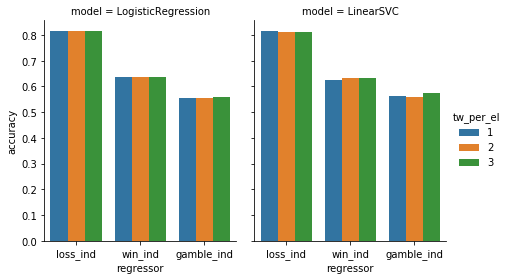

In [147]:
plot_param_vals('tw_per_el')

In [148]:
plot_param_vals('elecs')

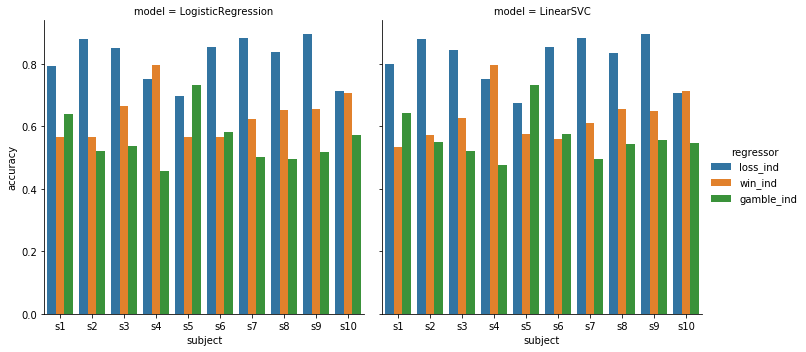

In [149]:
plot_param_vals('subject')